In [5]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")


In [6]:
class KMeans:
    def __init__(self, n_clusters=3, max_iter=300, tol=0.0001, random_state=None, init='random'):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.random_state = random_state
        self.init = init
        self.cluster_centers_ = None

    def fit(self, X):
        np.random.seed(self.random_state)
        
        if isinstance(self.init, str) and self.init == 'random':
            # Randomly initialize cluster centers
            indices = np.random.choice(X.shape[0], self.n_clusters, replace=False)
            self.cluster_centers_ = X[indices]
        elif hasattr(self.init, "__array__"):
            # Set the initial cluster centers
            assert self.init.shape[0] == self.n_clusters, "init array must have n_clusters rows"
            self.cluster_centers_ = self.init
        else:
            raise ValueError("Invalid value for init. Allowed string 'random' or an ndarray.")

        for i in range(self.max_iter):
            # Assign clusters
            distances = np.sqrt(((X[:, np.newaxis] - self.cluster_centers_)**2).sum(axis=2))
            self.labels_ = np.argmin(distances, axis=1)
            
            # Update cluster centers
            new_centers = np.array([X[self.labels_ == j].mean(axis=0) for j in range(self.n_clusters)])
            
            # Check for convergence
            if np.all(np.linalg.norm(new_centers - self.cluster_centers_, axis=1) <= self.tol):
                break
            
            self.cluster_centers_ = new_centers

    def predict(self, X):
        distances = np.sqrt(((X[:, np.newaxis] - self.cluster_centers_)**2).sum(axis=2))
        return np.argmin(distances, axis=1)

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

# K-means Clustering on the Iris Dataset

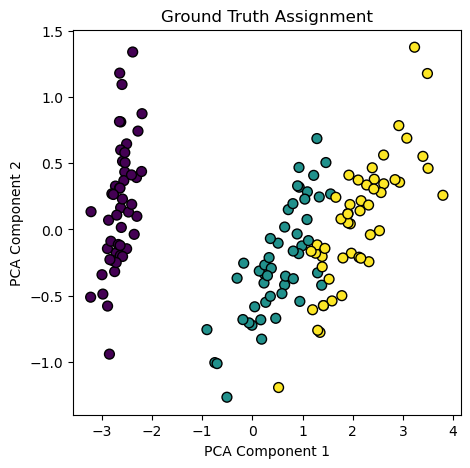

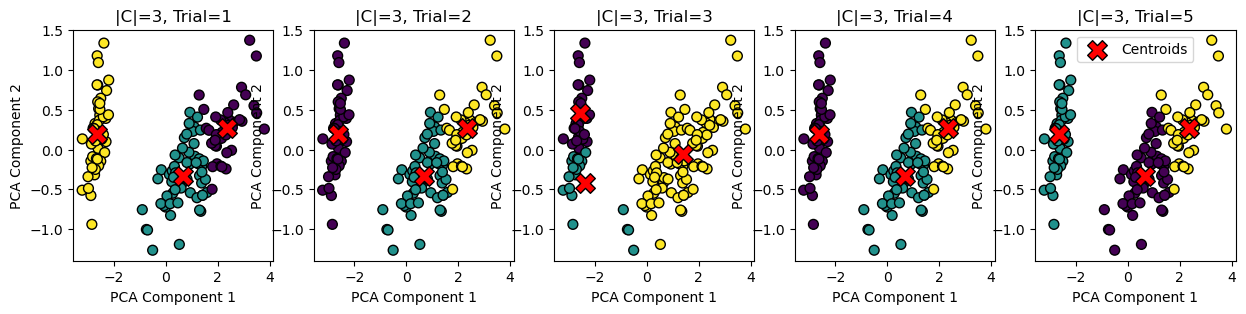

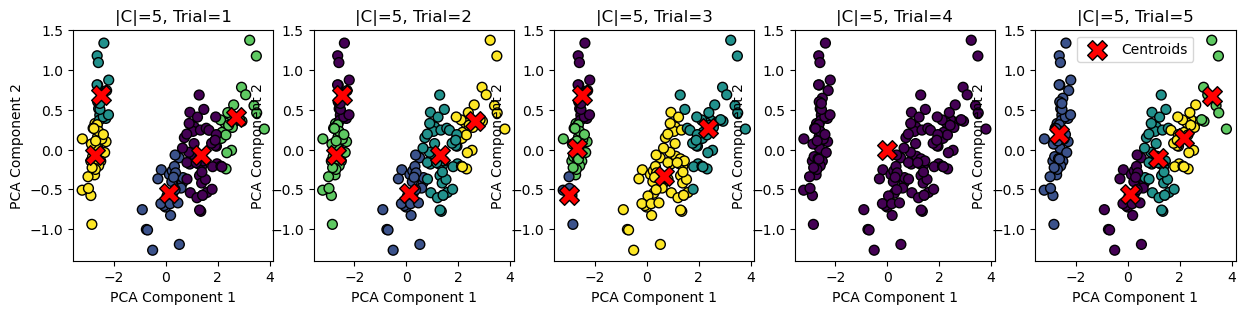

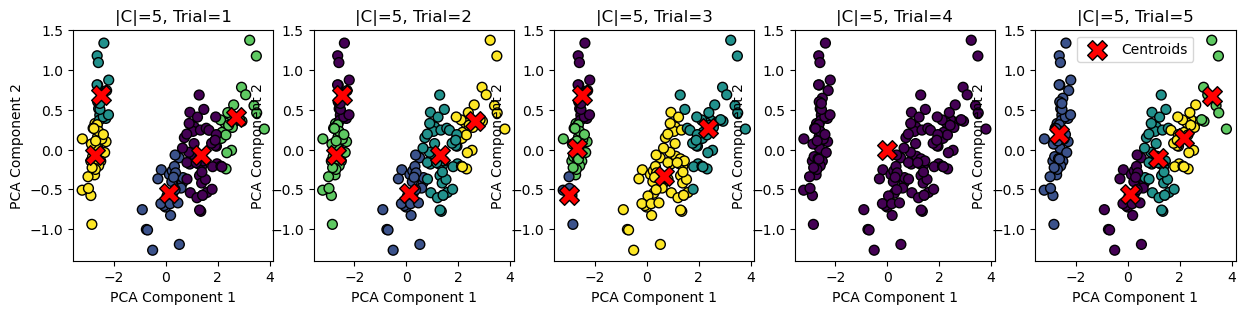

In [9]:
# Load the Iris dataset
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

# Apply PCA for visualization purposes
pca = PCA(n_components=2)
X_iris_pca = pca.fit_transform(X_iris)

# Visualize the ground truth assignment
plt.figure(figsize=(5, 5))
plt.scatter(X_iris_pca[:, 0], X_iris_pca[:, 1], c=y_iris, cmap='viridis', edgecolor='k', s=50)
plt.title('Ground Truth Assignment')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

# Apply K-means with different cluster sizes |C| = {3, 4, 5}
for n_clusters in [3, 5, 5]:
    plt.figure(figsize=(15, 3))
    for i in range(5):  # 5 random initializations
        kmeans = KMeans(n_clusters=n_clusters, init='random', random_state=i)
        y_kmeans = kmeans.fit_predict(X_iris_pca)
        centroids = kmeans.cluster_centers_
        
        plt.subplot(1, 5, i+1)
        plt.scatter(X_iris_pca[:, 0], X_iris_pca[:, 1], c=y_kmeans, cmap='viridis', edgecolor='k', s=50)
        plt.scatter(centroids[:, 0], centroids[:, 1], s=200, marker='X', c='red', edgecolor='black', label='Centroids')
        plt.title(f'|C|={n_clusters}, Trial={i+1}')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
    plt.legend()
    plt.show()


In the K-means clustering of the Iris dataset with ∣C∣=3, we see a good separation of the distinct setosa species but some misclassification between the versicolor and virginica species, likely due to their overlapping distributions and K-means’ assumption of spherical clusters. Despite the algorithm's stable performance across multiple trials, its limitations become evident when facing non-spherical clusters or clusters of different sizes. Employing more sophisticated initialization methods like k-means++ or switching to models that account for cluster covariance, such as Gaussian Mixture Models, could provide improved clustering fidelity in such scenarios.

# Color Quantization using K-means

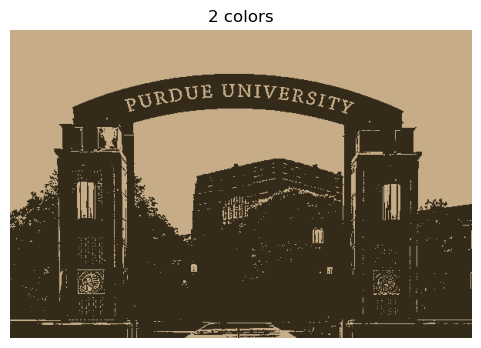

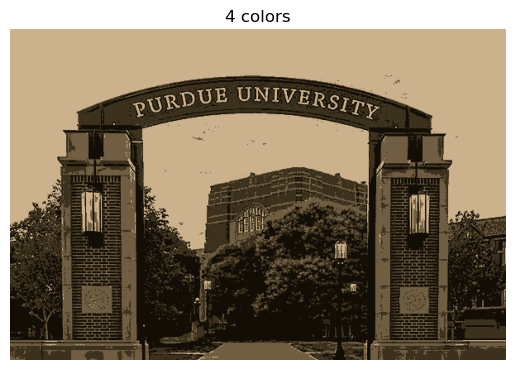

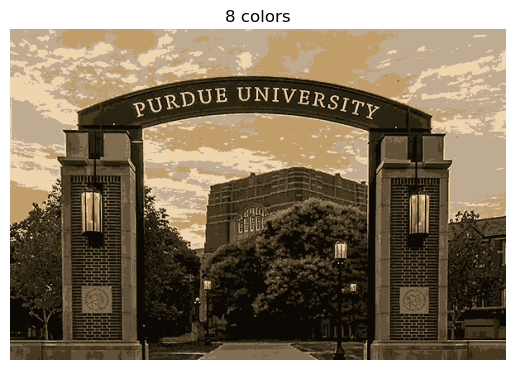

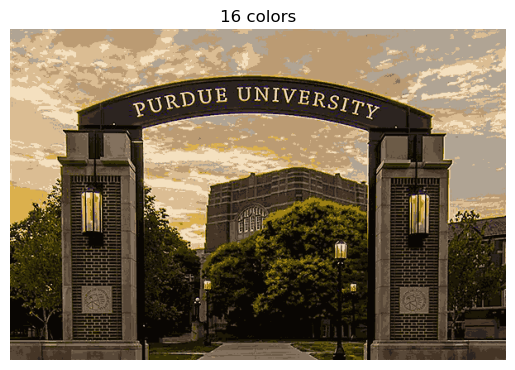

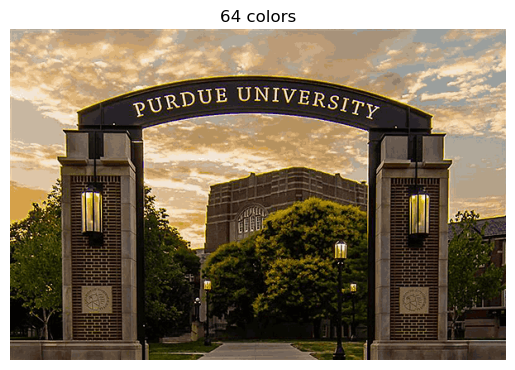

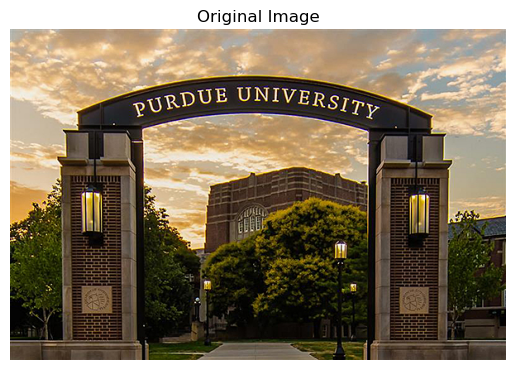

In [11]:
def color_quantization(image_path, n_colors):
    # Read the image
    img = Image.open(image_path)
    img_data = np.array(img, dtype=np.float64) / 255

    # Reshape the image data into a 2D array where each row is a color
    w, h, d = original_shape = tuple(img_data.shape)
    assert d == 3
    image_array = np.reshape(img_data, (w * h, d))

    # Fit the K-means algorithm on the image data
    kmeans = KMeans(n_clusters=n_colors, random_state=0)
    kmeans.fit(image_array)
    labels = kmeans.predict(image_array)
    
    # Create a new image by replacing each pixel color with its corresponding centroid
    new_img_array = kmeans.cluster_centers_[labels]
    
    # Reshape and convert to uint8 for display
    new_img = np.reshape(new_img_array, original_shape)
    new_img = (new_img * 255).astype(np.uint8)

    return new_img

# File path to the input image
image_path = './hw4_data/hw4_purdue.jpg'

# List of cluster sizes to try
n_colors_list = [2, 4, 8, 16, 64]

# Apply color quantization and visualize the results
plt.figure(figsize=(6, 4))
for i, n_colors in enumerate(n_colors_list):
    quantized_image = color_quantization(image_path, n_colors)
    plt.imshow(quantized_image)
    plt.title(f'{n_colors} colors')
    plt.axis('off')
    plt.show()
    
original_img = Image.open(image_path)

# Display the original image
plt.imshow(original_img)
plt.title('Original Image')
plt.axis('off')  # Hide axis
plt.show()
